In [1]:
from ea_bo import optimize

initializing ocelot...


## Preamble

Remarks: I would set a higher max_step for BO, maybe 100/150?

## Actual BO

  0%|          | 0/10 [00:00<?, ?it/s]/Users/jankaiser/Documents/DESY/ares-ea-rl/ea_bo.py:173: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:204.)
  X = torch.cat([X, torch.tensor([new_action])])
11it [01:09,  6.34s/it]                        
/usr/bin/lp: No such file or directory


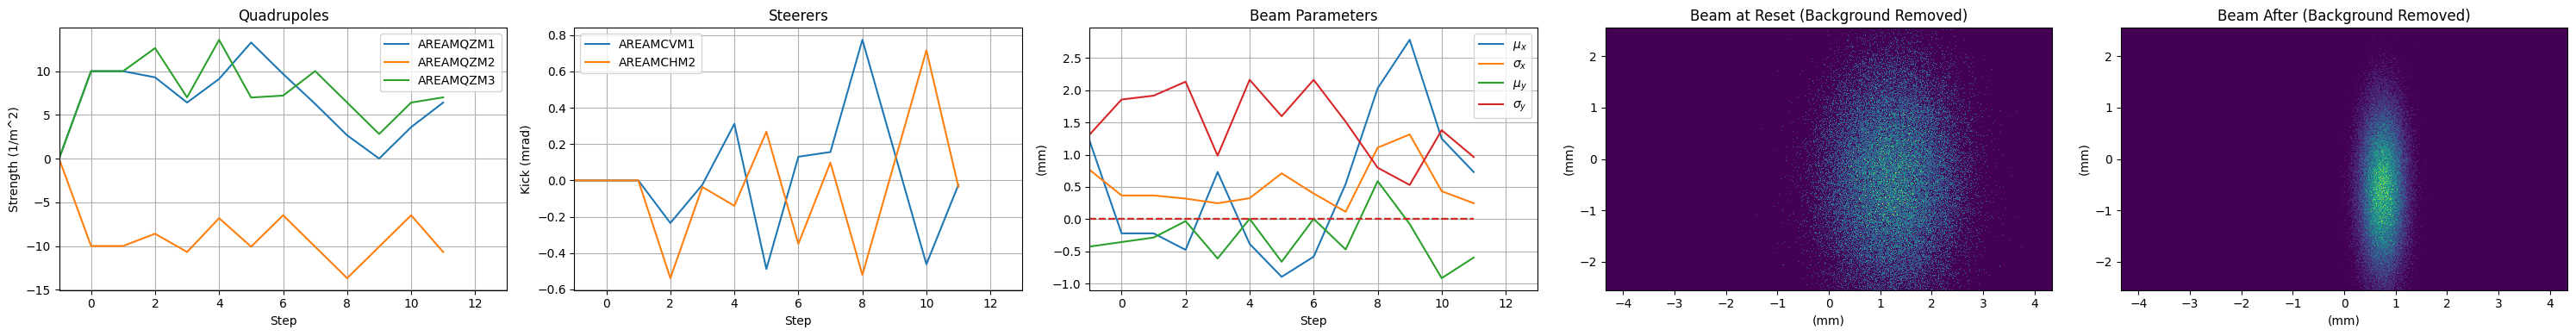

In [2]:
# hopefully this would run :)

optimize(
    target_mu_x=0.0,  # 0.4249e-3,
    target_sigma_x=0.0,
    target_mu_y=0.0,  # 1.1048e-3,
    target_sigma_y=0.0,
    target_mu_x_threshold=3.16e-6,
    target_mu_y_threshold=3.16e-6,
    target_sigma_x_threshold=3.16e-6,
    target_sigma_y_threshold=3.16e-6,
    max_steps=10,
    model_name="BO",
    logbook=True,
    data_log_dir="data_recordings_bo",
    progress_bar=True,
    callback=None,
    obj_function="logmae",
    acquisition="EI",
    init_x=None,
    init_samples=5,
    filter_action=None,
)


In [ ]:
# hopefully this would run :)

# optimize(
#     target_mu_x=0.4249e-3,
#     target_sigma_x=0.0,
#     target_mu_y=1.1048e-3,
#     target_sigma_y=0.0,
#     target_mu_x_threshold=3.16e-6,
#     target_mu_y_threshold=3.16e-6,
#     target_sigma_x_threshold=3.16e-6,
#     target_sigma_y_threshold=3.16e-6,
#     max_steps=100,
#     model_name="BO",
#     logbook=True,
#     callback=None,
#     obj_function='logmae',
#     acquisition="EI",
#     init_x = None,
#     init_samples = 5,
#     filter_action = None,
# )
